In [1263]:
import scipy.io
import numpy as np
import ssm
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold, KFold

data = scipy.io.loadmat('/home/bryancsouza/bryancsouza@neuro.ufrn.br/Jan Dataset/Results/preprocess_v2.mat');

animal = data['animal'];
dat = data['data'];
hasCA1 = data['hasCA1'];
hasPF = data['hasPF'];

learned = data['learned'];
srate = data['srate'];
ses = data['ses'];
trainingday = data['trainingday'];

CA1=1;
PFC=2;
doplot = False;
valid_ses=np.concatenate((hasCA1.T, hasPF.T, hasCA1.T & hasPF.T), axis=1);

valid_neurons= np.array([CA1, PFC, []]);
nbin=25;
nsub = 1;
nsur=1000;

nneurons_all = [];
ntrials_all = [];

area_labels=['CA1', 'PFC', 'CA1 & PFC'];


for ises in np.arange(60,72):
# for ises in np.arange(72,93):

    if ises==59:
        continue
        
    print(ises)
    SPIKES = 0
    EVENTS = 1
    AREA=3

    #spktimes = double(data(ises).Spikes{1})/srate;
    spktimes = np.double(dat[0,ises][SPIKES][0,0])/srate
    spkid = dat[0,ises][SPIKES][1,0]

    area = dat[0,ises][AREA][0,0]

    etime = dat[0,ises][EVENTS][0,0]/srate
    etype = dat[0,ises][EVENTS][1,0]

    spkid = spkid-min(spkid)
    classes = np.unique(spkid)

    #area_aux =[];
    #area_aux(classes) =area;
    area_aux = np.zeros(max(classes)+1)
    area_aux[classes] = area



    nneurons=np.zeros(len(area_labels));
    for iarea in np.arange(len(area_labels)-1):
        nneurons[iarea] = sum(area_aux[np.unique(spkid)]==valid_neurons[iarea]);


    temp = np.where(nneurons!=0)
    for iarea in temp[0]:
        area_aux[np.unique(spkid)]
        valid_neurons[0]
        area_aux[np.unique(spkid)]==valid_neurons[iarea]


        if sum(nneurons==0)>1:
            lessneuron = 0;
        else:
            nneurons[-1]= sum(nneurons[:-1]);
            lessneuron = min(nneurons[:-1]);
            if np.mod(lessneuron,2)==1:
                lessneuron-=1

        (idx1,v) = np.where(etype == 1)
        (idx2,v) = np.where(etype == 2)

        trialtype = np.concatenate((1*np.ones(len(idx1)),2*np.ones(len(idx2))))
        idx = np.concatenate((idx1,idx2))

        trialtime = etime[idx]
        trialtime = np.concatenate((trialtime, trialtime+3), axis=1)

        #timebins = np.arange(-1,4,0.001)

        nsub = 1
        for isub in np.arange(nsub):
            v = (min([len(idx1), len(idx2)]))
            idx1_ = np.random.choice(idx1,v,False)
            idx2_ = np.random.choice(idx2,v,False)
            idx1_ = np.sort(idx1_)
            idx2_ = np.sort(idx2_)

            trialtype = np.concatenate((1*np.ones(len(idx1_)),2*np.ones(len(idx2_))))
            idx = np.concatenate((idx1_,idx2_))

            trialtime = etime[idx]
            trialtime = np.concatenate((trialtime, trialtime+3), axis=1)



        print([len(idx1_), len(idx2_)])
        
#         itrial = 0
#         valid = np.logical_and(spktimes>=trialtime[itrial,0]-1, spktimes<trialtime[itrial,1]+1)
#         spktimes_ = spktimes[valid];
#         spktimes_ = spktimes_-trialtime[itrial,0];
#         spkid_ = spkid[valid];
#         ineuron=0
#         idx = np.where(spkid_==classes[ineuron])

#         (idx,) = np.where(spkid_==classes[ineuron])
#         idx

        spikes_ = np.zeros([len(trialtime),len(classes)],dtype=list)
        binlen = 20
        timebins = np.arange(-1,4,binlen/1000)
        psth = []
        spikes_mat = np.zeros([len(timebins)-1,len(classes),len(trialtime)],dtype=int)
        for itrial in np.arange(len(trialtime)):
            valid = np.logical_and(spktimes>=trialtime[itrial,0]-1, spktimes<trialtime[itrial,1]+1)
            spktimes_ = spktimes[valid];
            spktimes_ = spktimes_-trialtime[itrial,0];
            spkid_ = spkid[valid];

            for ineuron in np.arange(len(classes)):

                (idx,) = np.where(spkid_==classes[ineuron])

                spikes_[itrial,ineuron] = spktimes_[idx]

                (counts,v) = np.histogram(spktimes_[idx],timebins)


                spikes_mat[:,ineuron,itrial] = counts

            psth.append(np.squeeze(spikes_mat[:,:,itrial]))

        #simple_hmm.log_lambdas = np.log(lambdas)
        #simple_hmm.transitions.log_Ps = np.log(A)
        #lls = simple_hmm.fit(train_datas, method='em')

        X_train, X_test, y_train, y_test = train_test_split(psth, trialtype, test_size=0.1, random_state=0)


        skf = StratifiedKFold(n_splits=5)
        psth_ = np.asarray(psth)

        nneurons_ = len(classes)    # dimension of the observations (Neurons)
        test_ll_all =[]
        test_bic_all=[];
        minbic = np.Inf
        count=0;
        maxstate = 20
        ll = np.zeros(maxstate);
        bic = np.zeros(maxstate);
        bic[:]= np.nan;
        hmm_best=[np.nan, np.nan]
        statevec =  np.arange(2,maxstate)
        for nstates in statevec:    # number of discrete states

            p0=np.zeros(nstates)
            p0[0]=1
            # Manually set the initial state distribution
            init_dist = ssm.init_state_distns.FixedInitialStateDistribution(nstates,
                                                                            nneurons,
                                                                            pi0 = p0)
            test_ll=[]
            test_bic=[]
            hmm_temp=[]
            for train, test in skf.split(psth, trialtype):

                diag= np.random.rand(nstates)*0.02+0.98
                # Manually initialize the transition probabilities
                A = np.zeros([nstates,nstates])
                for istate in np.arange(nstates):
                    A[istate,:] = (1-diag[istate])/(nstates-1)
                    A[istate,istate] = diag[istate]

                hmm_ = ssm.HMM(nstates,
                               nneurons_,
                               observations="poisson",
                               init_state_distn=init_dist)

                #psth_[train]
                #trialtype[train]
                lambdas = np.random.rand(nstates,nneurons_)

                hmm_.transitions.log_Ps = np.log(A)
                hmm_.log_lambdas = np.log(lambdas)

                psth_train=[]
                for idx in train:
                    psth_train.append(psth[idx])

                psth_test=[]
                for idx in test:
                    psth_test.append(psth[idx])

                train_lls = hmm_.fit(psth_train, method = 'em')
                ll_=hmm_.log_likelihood(psth_test)
                test_ll.append(ll_)

                bic_= -2*ll_+(nstates*(nstates-1)+nstates*nneurons_)*np.log(len(train))
                test_bic.append(bic_)
                hmm_temp.append(hmm_)

            ll[nstates] = np.nanmean(test_ll)
            bic[nstates] = np.nanmin(test_bic)
            imin = np.nanargmin(test_bic)
            hmm_best.append(hmm_temp[imin])

            if minbic>bic[nstates]:
                minbic = bic[nstates]
                count=0

            else:
                count=count+1

            if count==4:
                break

            test_ll_all.append(test_ll)
            test_bic_all.append(test_bic)

        ibest = np.nanargmin(bic)
        hmm_bic = hmm_best[ibest]
        hmm_bic.fit(psth, method = 'em')


        filename = 'HMM_bic_ses' + str(ises) + 'area_' + str(iarea) + '.npy'
        np.save(filename, [hmm_bic, psth, trialtype, statevec, bic])

        

60
[45, 45]



61
[42, 42]



62
[42, 42]



63
[46, 46]



64
[43, 43]



65
[36, 36]



66
[35, 35]



67
[43, 43]



68
[48, 48]



69
[47, 47]



70
[37, 37]



71
[39, 39]


In [1252]:
print(ises)
trialtime

59


array([], shape=(0, 2), dtype=float64)

In [953]:
np.sort(np.random.choice(idx1[:11],10,False))

array([  0,  43,  67, 129, 162, 178, 193, 210, 228, 242])

In [630]:
from scipy.stats import ranksums
import warnings
warnings.filterwarnings('ignore')

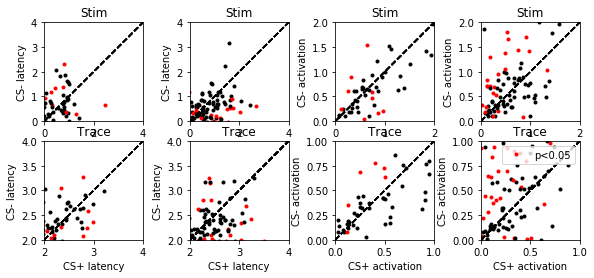

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


In [765]:
#for ises in np.arange(72,92):
m_latency =[]
fig = plt.figure(figsize=(10, 4))
for ilearn in range(2):
    
    # plot latency
    for ises in np.where(learned[:,0]==ilearn)[0]:
        if ises<72:
            continue
        for iarea in [1]:
            filename = 'HMM_bic_ses' + str(ises) + 'area_' + str(iarea) + '.npy'

            data = np.load(filename,allow_pickle=True)

            hmm_bic, psth, trialtype, statevec, bic = data

            nstates=hmm_bic.K

            # get a random trial
            test_trial_spikes = psth[np.random.choice(len(psth))]
            posterior = hmm_bic.filter(test_trial_spikes)

#             # plot posterior of states for a single test trial
#             plt.figure(figsize=(10, 4))
#             for i in range(nstates):
#                 plt.plot(timebins[:-1]+binlen/1000/2,posterior[:,i], label="State %d" % i)
#             plt.legend()

            ntrial = len(psth)
            posterior = np.zeros((psth[0].shape[0],nstates,ntrial))
            # get trial mean
            count = 0
            for test_trial in psth:
                posterior[:,:,count] = hmm_bic.filter(test_trial)
                count+=1

            active_trials = np.max(posterior,axis=0)
#             # plot posterior of states for a single test trial
#             plt.figure(figsize=(10, 4))

#             for i in range(nstates):
#                 idx = np.where(active_trials[i,:]>0.80)[0]
#                 plt.plot(timebins[:-1]+binlen/1000/2,np.mean(posterior[:,i,idx],1), label="State %d" % i)
#             plt.legend()


            istim = np.max(np.where(timebins<0)[0])
            itrace = np.max(np.where(timebins<2)[0])
            irwd = np.max(np.where(timebins<3)[0])
            latency = np.zeros([ntrial, nstates])
            activation = np.zeros([ntrial, nstates])
            dt = timebins[1]-timebins[0]
            for itrial in np.arange(posterior.shape[2]):
                for istate in range(nstates):
                    idx = np.where(posterior[istim:,istate,itrial]>0.80)[0]
                    idx2 = np.where(posterior[istim:itrace,istate,itrial]>0.80)[0]

                    if idx.size ==0:
                        latency[itrial,istate] = np.nan
                        activation[itrial,istate] = np.nan
                    else:
                        latency[itrial,istate] = timebins[istim+idx[0]]
                        activation[itrial,istate] = len(idx2)*dt


            m_latency.append(np.nanmean(latency,axis=0))


#             # plot latency
#             f = plt.figure(figsize=(10, 4))
            ax = plt.subplot(2,4,1+ilearn)
            for istate in range(nstates):
                latency1 = np.nanmean(latency[trialtype==1,istate],axis=0)
                latency2 = np.nanmean(latency[trialtype==2,istate],axis=0)

                aux1=latency[trialtype==1,istate]
                aux1=aux1[~np.isnan(aux1)]
                aux2=latency[trialtype==2,istate]
                aux2=aux2[~np.isnan(aux2)]
                
                stats ,p = ranksums(aux1,aux2)
                if p<0.05:
                    plt.plot(latency1,latency2,'.',color='r')
                else:
                    plt.plot(latency1,latency2,'.',color = 'k')
#                 plt.plot(latency1,latency2,'.', label="State %d" % istate)

            plt.xlim([0, 4])
            plt.ylim([0, 4])
            plt.plot(plt.xlim(),plt.ylim(),'k--')
            plt.xlabel('CS+ latency')
            plt.ylabel('CS- latency')
            plt.title('Stim')
            ax.set_aspect('equal')
            #plt.legend()


            ax = plt.subplot(2,4,3+ilearn)
            for istate in range(nstates):
                activation1 = np.nanmean(activation[trialtype==1,istate],axis=0)
                activation2 = np.nanmean(activation[trialtype==2,istate],axis=0)
                
                aux1=activation[trialtype==1,istate]
                aux1=aux1[~np.isnan(aux1)]
                aux2=activation[trialtype==2,istate]
                aux2=aux2[~np.isnan(aux2)]
                
                stats ,p = ranksums(aux1,aux2)
                if p<0.05:
                    plt.plot(activation1,activation2,'.',color='r')
                else:
                    plt.plot(activation1,activation2,'.',color = 'k')
#                 plt.plot(activation1,activation2,'.', label="State %d" % istate)

            plt.xlim([0, 2])
            plt.ylim([0, 2])
            plt.plot(plt.xlim(),plt.ylim(),'k--')
            plt.xlabel('CS+ activation')
            plt.ylabel('CS- activation')
            plt.title('Stim')
            ax.set_aspect('equal')
            #plt.legend()



            latency = np.zeros([ntrial, nstates])
            activation = np.zeros([ntrial, nstates])
            for itrial in np.arange(posterior.shape[2]):
                for istate in range(nstates):

                    idx = np.where(posterior[itrace:,istate,itrial]>0.80)[0]
                    idx2 = np.where(posterior[itrace:irwd,istate,itrial]>0.80)[0]

                    if idx.size ==0:
                        latency[itrial,istate] = np.nan
                        activation[itrial,istate] = np.nan
                    else:
                        latency[itrial,istate] = timebins[itrace+idx[0]]
                        activation[itrial,istate] = len(idx2)*dt

            #m_latency.append(np.nanmean(latency,axis=0))

            # plot latency
            ax2 = plt.subplot(2,4,5+ilearn)
            for istate in range(nstates):
                latency1 = np.nanmean(latency[trialtype==1,istate],axis=0)
                latency2 = np.nanmean(latency[trialtype==2,istate],axis=0)

                aux1=latency[trialtype==1,istate]
                aux1=aux1[~np.isnan(aux1)]
                aux2=latency[trialtype==2,istate]
                aux2=aux2[~np.isnan(aux2)]
                
                stats ,p = ranksums(aux1,aux2)
                if p<0.05:
                    plt.plot(latency1,latency2,'.',color='r')
                else:
                    plt.plot(latency1,latency2,'.',color = 'k')
#                 plt.plot(latency1,latency2,'.', label="State %d" % istate)

            plt.xlim([2, 4])
            plt.ylim([2, 4])
            plt.plot(plt.xlim(),plt.ylim(),'k--')
            plt.xlabel('CS+ latency')
            plt.ylabel('CS- latency')
            plt.title('Trace')
            ax2.set_aspect('equal')


            ax = plt.subplot(2,4,7+ilearn)
            for istate in range(nstates):
                activation1 = np.nanmean(activation[trialtype==1,istate],axis=0)
                activation2 = np.nanmean(activation[trialtype==2,istate],axis=0)
                aux1=activation[trialtype==1,istate]
                aux1=aux1[~np.isnan(aux1)]
                aux2=activation[trialtype==2,istate]
                aux2=aux2[~np.isnan(aux2)]
                
                stats ,p = ranksums(aux1,aux2)
                if p<0.05:
                    plt.plot(activation1,activation2,'.',color='r')
                else:
                    plt.plot(activation1,activation2,'.',color = 'k')
#                     plt.plot(activation1,activation2,'.',color = (0.2, 0.2, 0.2), label="n.s.")

            plt.xlim([0, 1])
            plt.ylim([0, 1])
            plt.plot(plt.xlim(),plt.ylim(),'k--')
            plt.xlabel('CS+ activation')
            plt.ylabel('CS- activation')
            plt.title('Trace')
            ax.set_aspect('equal')
            
plt.plot(-1,-1,'.',color ='r', label="p<0.05")
plt.legend()


plt.show()
fig.savefig('Latency_Activation_' + area_labels[iarea] + '_v1.png')
fig.savefig('Latency_Activation_' + area_labels[iarea] + '_v1.eps')

In [759]:
istate=3
ranksums(activation[trialtype==1,3],activation[trialtype==2,3])
activation1 = np.nanmean(activation[trialtype==1,istate],axis=0)
activation2 = np.nanmean(activation[trialtype==2,istate],axis=0)
activation1
activation2
np.isnan(aux2)

NameError: name 'aux2' is not defined

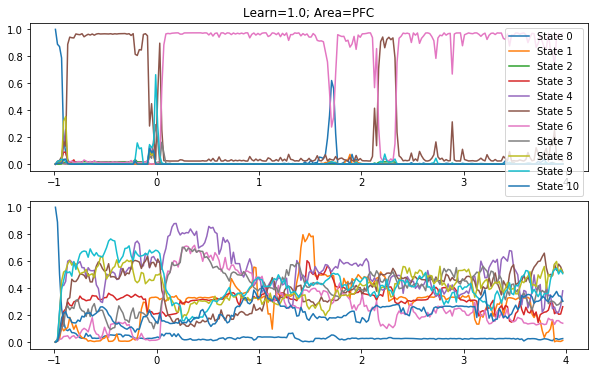

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


In [743]:
#for ises in np.arange(72,92):
m_latency =[]
fig = plt.figure(figsize=(10, 6))
for ilearn in [1]: #range(2):
    
    # plot latency
    for ises in [91]: #np.where(learned[:,0]==ilearn)[0]:
        if ises<72:
            continue
        for iarea in [1]:
            filename = 'HMM_bic_ses' + str(ises) + 'area_' + str(iarea) + '.npy'

            data = np.load(filename,allow_pickle=True)

            hmm_bic, psth, trialtype, statevec, bic = data

            nstates=hmm_bic.K

            # get a random trial
            test_trial_spikes = psth[np.random.choice(len(psth))]
            posterior = hmm_bic.filter(test_trial_spikes)

            # plot posterior of states for a single test trial
            plt.subplot(2,1,1)
            for i in range(nstates):
                plt.plot(timebins[:-1]+binlen/1000/2,posterior[:,i], label="State %d" % i)
            plt.legend()
            plt.title('Learn=' +str(learned[ises,0]) +'; Area=' + area_labels[iarea])

            ntrial = len(psth)
            posterior = np.zeros((psth[0].shape[0],nstates,ntrial))
            # get trial mean
            count = 0
            for test_trial in psth:
                posterior[:,:,count] = hmm_bic.filter(test_trial)
                count+=1

            active_trials = np.max(posterior,axis=0)
            # plot posterior of states for a single test trial
            plt.subplot(2,1,2)

            for i in range(nstates):
                idx = np.where(active_trials[i,:]>0.80)[0]
                plt.plot(timebins[:-1]+binlen/1000/2,np.mean(posterior[:,i,idx],1), label="State %d" % i)
#             plt.legend()
plt.show()
fig.savefig('HMM_example' + area_labels[iarea] + '_ses' + str(ises)+ '.png')
fig.savefig('HMM_example' + area_labels[iarea] + '_ses' + str(ises)+ '.eps')

5
5


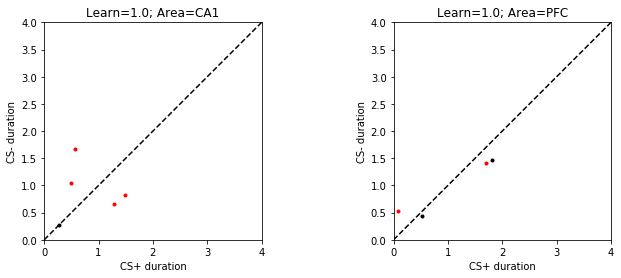

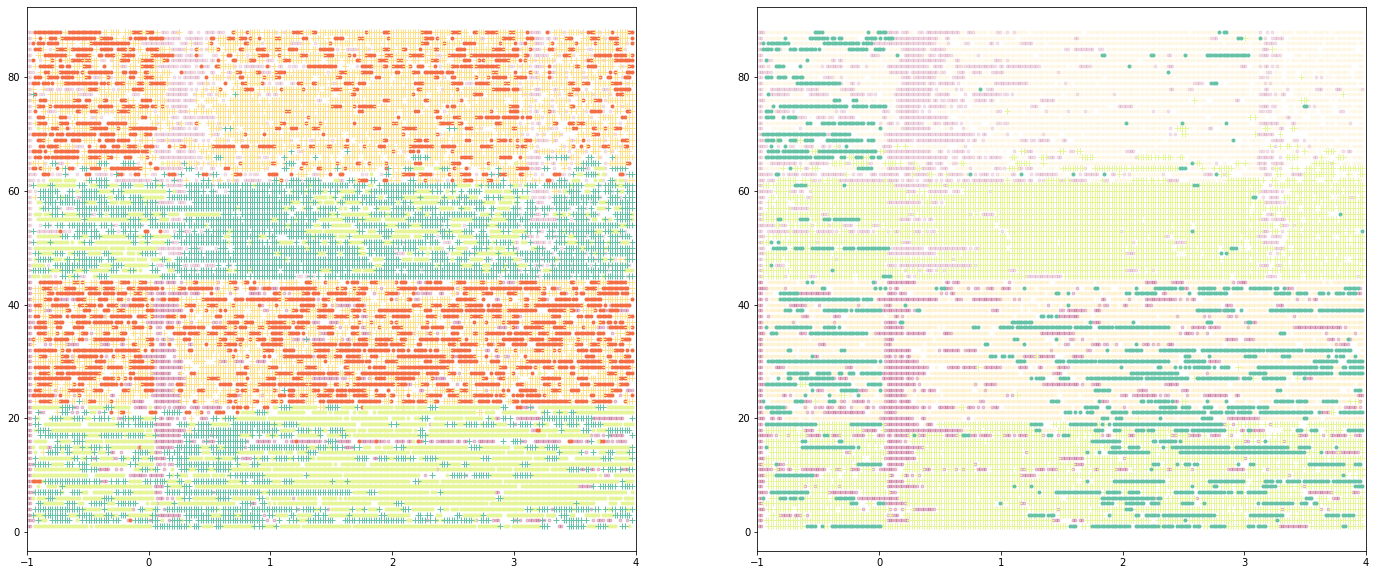

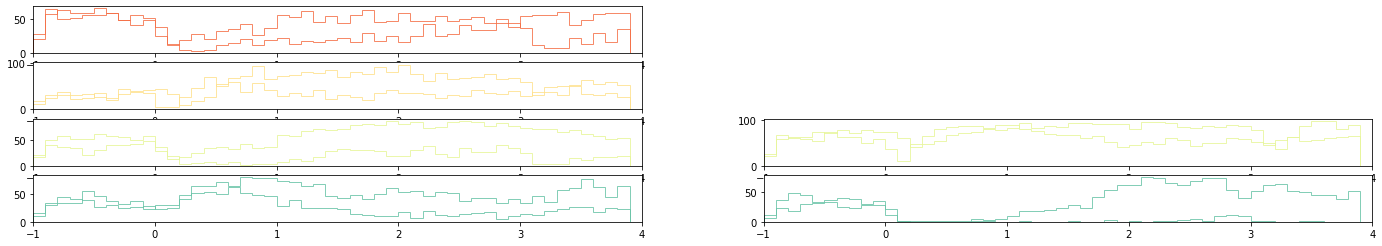

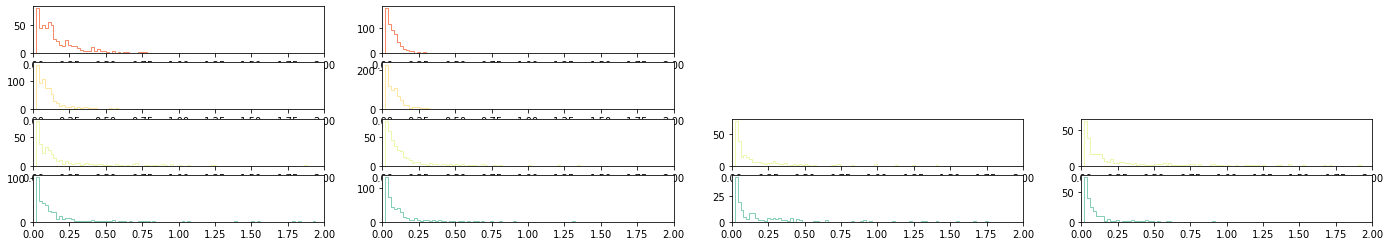

In [1248]:
#for ises in np.arange(72,92):
m_latency =[]
thresh = 0.6
fig1 = plt.figure(figsize=(24, 4))
fig2 = plt.figure(figsize=(24, 10))
fig3 = plt.figure(figsize=(24, 5))
fig4 = plt.figure(figsize=(24, 5))
for ilearn in [1]: #range(2):
    
    # plot latency
    #interesting: 79, 85, 87
    for ises in [85]: #np.where(learned[:,0]==ilearn)[0]: 
        if ises<72:
            continue
        for iarea in [0,1]:
            filename = 'HMM_bic_ses' + str(ises) + 'area_' + str(iarea) + '.npy'

            data = np.load(filename,allow_pickle=True)

            hmm_bic, psth, trialtype, statevec, bic = data

            nstates=hmm_bic.K
            ntrial = len(psth)
            
            cmap = plt.cm.get_cmap('Spectral')
            
            print(nstates)
            
            istim = np.max(np.where(timebins<0)[0])
            itrace = np.max(np.where(timebins<2)[0])
            irwd = np.max(np.where(timebins<3)[0])
            
            activation = np.zeros([ntrial, nstates])
            latency = np.zeros([ntrial, nstates])
            act_times1= []
            act_times2= []
            most_act = np.zeros([ntrial,len(psth[0])])-1
            for itrial in range(ntrial):
                
                # get trial
                test_trial_spikes = psth[itrial]
                posterior = hmm_bic.filter(test_trial_spikes)
                for istate in range(nstates):
                    if len(act_times1)<=istate:
                        act_times1.append([])
                        act_times2.append([])
                    
                    idx = np.where(posterior[:,istate]>thresh)[0]
                    idx2 = np.where(posterior[istim:irwd,istate]>thresh)[0]
                    most_act[itrial, idx2] = istate
                    
                    if idx2.size ==0:
                        latency[itrial,istate] = np.nan
                        activation[itrial,istate] = np.nan
                    else:
                        if trialtype[itrial]==1:
                            act_times1[istate] = act_times1[istate] + list(timebins[idx])
                        else:
                            act_times2[istate] =act_times2[istate] + list(timebins[idx])
                        latency[itrial,istate] = timebins[istim+idx2[0]]
                        activation[itrial,istate] = len(idx2)*dt
            isi=[]
            dur=[]
            for istate in range(nstates):
                if len(dur)<=istate:
                        dur.append([])
                        isi.append([])
                     
                for itrial in range(ntrial):
                    idx = np.where(most_act[itrial,:]==istate)[0]
                    
                    if len(idx)>0:
                        istart = np.concatenate( (np.array([0]), np.where(np.diff(idx)>1)[0]+1))
                        iend = np.concatenate((np.where(np.diff(idx)>1)[0], np.array([len(idx)-1])))

                        dur[istate] = dur[istate]+ list(timebins[idx[iend]]-timebins[idx[istart]]+dt)
                        isi[istate] = isi[istate]+ list(-timebins[idx[iend[:-1]]] + timebins[idx[istart[1:]]]-dt)
                        

                                
            CSpstate=[];
            CSmstate=[];
            for istate in range(nstates):
                activation1 = np.nanmean(activation[trialtype==1,istate],axis=0)
                activation2 = np.nanmean(activation[trialtype==2,istate],axis=0)
                
                aux1=activation[trialtype==1,istate]
                aux1=aux1[~np.isnan(aux1)]
                aux2=activation[trialtype==2,istate]
                aux2=aux2[~np.isnan(aux2)]
                
                stats ,p1 = ranksums(aux1,aux2)
                
                
                latency1 = np.nanmean(latency[trialtype==1,istate],axis=0)
                latency2 = np.nanmean(latency[trialtype==2,istate],axis=0)
                
                aux1=latency[trialtype==1,istate]
                aux1=aux1[~np.isnan(aux1)]
                aux2=latency[trialtype==2,istate]
                aux2=aux2[~np.isnan(aux2)]
                
                stats,p2 = ranksums(aux1,aux2)
                
                
                bins = np.arange(-1,4,0.1)
                
                bins2 = np.arange(0,2,0.02)
                if p1<0.05: #or p2<0.05:
                    
                    
                    plt.figure(fig1.number)
                    ax = plt.subplot(1,4,iarea+1)
                    
                    plt.plot(activation1,activation2,'.',color='r')
#                     plt.plot(latency1,latency2,'.',color='r')
                    
                    if activation1>activation2:
                        CSpstate.append(istate)
                        
                        plt.figure(fig3.number)
                        plt.subplot(nstates,2,istate*2+iarea+1)
                        plt.xlim([-1, 4])
#                         plt.hist(latency[trialtype==1,istate],bins=bins,alpha=0.8,color=cmap(istate/nstates),histtype='step')
                        plt.hist(np.asarray(act_times1[istate]),bins=bins,alpha=0.8,color=cmap(istate/nstates),histtype='step')
                        
                        plt.subplot(nstates,2,istate*2+iarea+1)
                        plt.xlim([-1, 4])
#                         plt.hist(latency[trialtype==2,istate],bins=bins,alpha=0.8,color=cmap(istate/nstates),histtype='step')
                        plt.hist(np.asarray(act_times2[istate]),bins=bins,alpha=0.8,color=cmap(istate/nstates),histtype='step')
    
                            
                        plt.figure(fig4.number)
                        plt.subplot(nstates,4,istate*4+(iarea)*2+2)
                        plt.xlim([0, 2])
                        plt.hist(np.asarray(dur[istate]),bins=bins2,alpha=0.8,color=cmap(istate/nstates),histtype='step')
                        
                        plt.subplot(nstates,4,istate*4+(iarea)*2+1)
                        plt.xlim([0, 2])
                        plt.hist(np.asarray(isi[istate]),bins=bins2,alpha=0.8,color=cmap(istate/nstates),histtype='step')
                        
                    else:
                        CSmstate.append(istate)
                        
                        plt.figure(fig3.number)
                        plt.subplot(nstates,2,istate*2+iarea+1)
                        plt.xlim([-1, 4])
#                         plt.hist(latency[trialtype==1,istate],bins=bins,alpha=0.8,color=cmap(istate/nstates),histtype='step')
                        plt.hist(np.asarray(act_times1[istate]),bins=bins,alpha=0.8,color=cmap(istate/nstates),histtype='step')
                        
                        plt.subplot(nstates,2,istate*2+iarea+1)
                        plt.xlim([-1, 4])
#                         plt.hist(latency[trialtype==2,istate],bins=bins,alpha=0.8,color=cmap(istate/nstates),histtype='step')
                        plt.hist(np.asarray(act_times2[istate]),bins=bins,alpha=0.8,color=cmap(istate/nstates),histtype='step')
    
                        plt.figure(fig4.number)
                        plt.subplot(nstates,4,istate*4+(iarea)*2+2)
                        plt.xlim([0, 2])
                        plt.hist(np.asarray(dur[istate]),bins=bins2,alpha=0.8,color=cmap(istate/nstates),histtype='step')
                        
                        plt.subplot(nstates,4,istate*4+(iarea)*2+1)
                        plt.xlim([0, 2])
                        plt.hist(np.asarray(isi[istate]),bins=bins2,alpha=0.8,color=cmap(istate/nstates),histtype='step')
                        
                else:
                    
                    plt.figure(fig1.number)
                    ax = plt.subplot(1,4,iarea+1)
                    
                    plt.plot(activation1,activation2,'.',color = 'k')
#                     plt.plot(latency1,latency2,'.',color = 'k')
#                 plt.plot(latency1,latency2,'.', label="State %d" % istate)

            
            plt.figure(fig1.number)
            plt.xlim([0, 4])
            plt.ylim([0, 4])
            plt.plot(plt.xlim(),plt.ylim(),'k--')
            plt.xlabel('CS+ duration')
            plt.ylabel('CS- duration')
            plt.title('Stim')
            ax.set_aspect('equal')
            #plt.legend()
                
                
            plt.title('Learn=' +str(learned[ises,0]) +'; Area=' + area_labels[iarea])
            
            
            count=0
            
            plt.figure(fig2.number)
            plt.subplot(1,2,iarea+1)
            
            for itrial in np.where(trialtype==2)[0]:
                count+=1
                # get trial
                test_trial_spikes = psth[itrial]
                posterior = hmm_bic.filter(test_trial_spikes)

                # plot posterior of states >0.8 for a single test trial
                timebinscenter = timebins[:-1]+binlen/1000/2
                for istate in range(nstates):
                    
                    idx = posterior[:,istate]>thresh
                    if istate in CSpstate:
                        plt.plot(timebinscenter[idx],count+0*posterior[idx,istate],'+', color=cmap(istate/nstates))
                    elif istate in CSmstate:
                        plt.plot(timebinscenter[idx],count+0*posterior[idx,istate],'.', color=cmap(istate/nstates))
                    else:
                        plt.plot(timebinscenter[idx],count+0*posterior[idx,istate],'.', color=cmap(istate/nstates),alpha=0.2)
                        
                    
            for itrial in np.where(trialtype==1)[0]:
                count+=1
                # get trial
                test_trial_spikes = psth[itrial]
                posterior = hmm_bic.filter(test_trial_spikes)

                # plot posterior of states >0.8 for a single test trial
                timebinscenter = timebins[:-1]+binlen/1000/2
                for istate in range(nstates):
                    
                    idx = posterior[:,istate]>thresh
                    if istate in CSpstate:
                        plt.plot(timebinscenter[idx],count+0*posterior[idx,istate],'+', color=cmap(istate/nstates))
                    elif istate in CSmstate:
                        plt.plot(timebinscenter[idx],count+0*posterior[idx,istate],'.', color=cmap(istate/nstates))
                    else:
                        plt.plot(timebinscenter[idx],count+0*posterior[idx,istate],'.', color=cmap(istate/nstates),alpha=0.1)
                    
                    
            plt.xlim([-1, 4])
            #plt.legend()
            

#             ntrial = len(psth)
#             posterior = np.zeros((psth[0].shape[0],nstates,ntrial))
#             # get trial mean
#             count = 0
#             for test_trial in psth:
#                 posterior[:,:,count] = hmm_bic.filter(test_trial)
#                 count+=1

#             active_trials = np.max(posterior,axis=0)
#             # plot posterior of states for a single test trial
#             plt.subplot(2,1,2)
#             for i in range(nstates):
#                 idx = np.where(active_trials[i,:]>0.80)[0]
#                 plt.plot(timebins[:-1]+binlen/1000/2,np.mean(posterior[:,i,idx],1), label="State %d" % i)
# #             plt.legend()
plt.show()
#fig.savefig('HMM_example' + area_labels[iarea] + '_ses' + str(ises)+ '.png')
#fig.savefig('HMM_example' + area_labels[iarea] + '_ses' + str(ises)+ '.eps')

In [1153]:
hmm_bic.params[2][0]


array([-2.0932835 , -1.89050365, -2.27352477, -2.60568205, -2.88697606,
       -2.81423586, -1.61657507, -2.03677429, -2.04786895, -2.08109964,
       -3.95994852, -1.45409325, -1.74047268, -3.35787159, -1.38609963,
       -2.11057463, -3.24441908, -2.7737622 , -1.97650524, -6.17854275,
       -4.49919751, -2.27507711, -3.81980657, -2.72399925, -5.15937419,
       -1.39696451, -4.56129583, -0.90006908, -1.74571099, -2.47823062,
       -1.27100195, -1.36684359, -2.29463723, -1.31434291, -7.27671629,
       -5.44203519, -5.20272969, -3.58746621, -1.04813699, -2.84414524,
       -2.0054285 , -5.18288571, -4.10225708, -4.65811658, -3.16506893,
       -2.77170139, -4.02801592, -3.73834983, -3.09820085, -4.92172884,
       -5.67709803, -5.65135578, -3.60892854, -2.97824302, -2.32540006,
       -4.80238706, -8.09105997, -4.91555012, -3.73005528, -6.14183171,
       -4.36013682, -2.83691598, -3.57015969, -3.38264373, -5.23527284,
       -5.96983638, -1.94959954, -4.34129801, -4.3733271 , -4.77

In [1083]:
act_times2

[[], [], [], [], [], [], [], [], [], [], []]

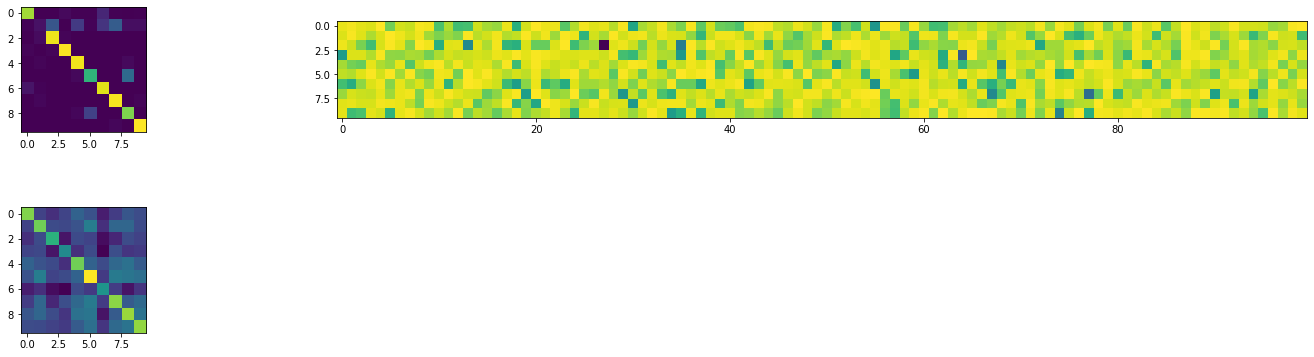

In [926]:
plt.figure(figsize=(24, 6))

grid = plt.GridSpec(2, 4, wspace=.6, hspace=.6)

plt.subplot(grid[0, 0])
plt.imshow(hmm_bic.transitions.transition_matrix)
hmm_bic.init_state_distn.initial_state_distn

plt.subplot(grid[0, 1:])

plt.imshow(hmm_bic.log_lambdas)

plt.subplot(grid[1, 0])
plt.imshow(np.matmul(np.exp(hmm_bic.log_lambdas),np.exp(hmm_bic.log_lambdas.T)))

plt.show()




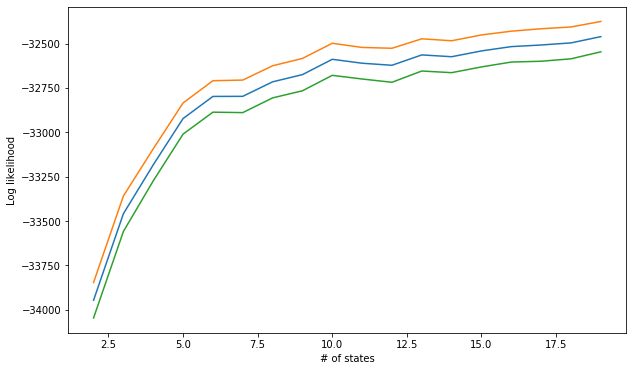

In [193]:


np.mean(test_ll_all,1)


plt.figure(figsize=(10,6))
m =np.mean(test_ll_all,1)
s =np.std(test_ll_all,1)/np.sqrt(len(train))
plt.plot(np.arange(2,20),m)

plt.plot(np.arange(2,20),m+s)
plt.plot(np.arange(2,20),m-s)


plt.ylabel("Log likelihood")
plt.xlabel("# of states")
#plt.legend()
#plt.tight_layout
plt.show()

84


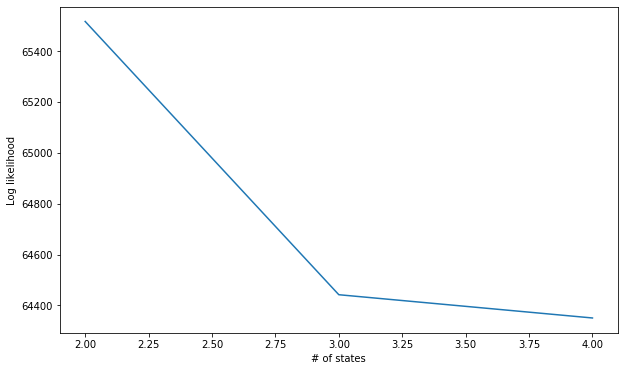

In [287]:
print(len(train))
# bic= -2 * np.mean(test_ll_all,1) + np.arange(3,20) * np.log(len(train))

plt.figure(figsize=(10,6))
m =bic


plt.plot(m)

plt.ylabel("Log likelihood")
plt.xlabel("# of states")
#plt.legend()
#plt.tight_layout
plt.show()

In [231]:
nstates


11

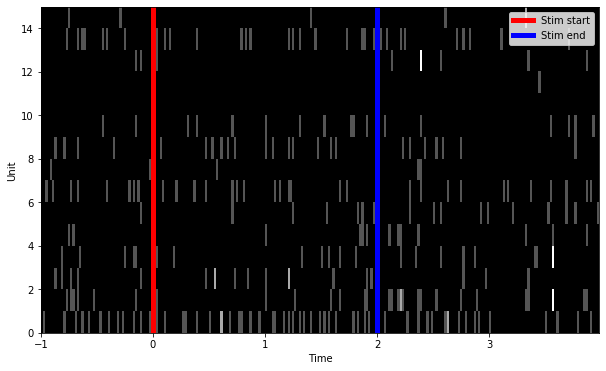

In [27]:


plt.figure(figsize=(10,6))
plt.imshow(spikes_mat[:,:,4].T, aspect='auto', cmap='gray',extent=(-1, max(timebins), 0, len(classes)))


plt.axvline(x=0, color='red', linewidth=5, label='Stim start')
plt.axvline(x=2, color='blue', linewidth=5, label='Stim end')
plt.ylabel("Unit")
plt.xlabel("Time")
plt.legend()
plt.tight_layout
plt.show()


In [45]:
nstates = 5    # number of discrete states
nneurons = len(classes)    # dimension of the observations (Neurons)


# Manually set the initial state distribution
init_dist = ssm.init_state_distns.FixedInitialStateDistribution(nstates,
                                                                nneurons,
                                                                pi0 = np.array([1, 0, 0, 0, 0]))

diag= np.random.rand(nstates)*0.02+0.98

# Manually initialize the transition probabilities
A = np.zeros([nstates,nstates])
for istate in np.arange(nstates):
    A[istate,:] = (1-diag[istate])/(nstates-1)
    A[istate,istate] = diag[istate]

hmm_ = ssm.HMM(nstates,
               nneurons,
               observations="poisson",
               init_state_distn=init_dist)

#lls = hmm_.fit(train_datas, method='em')


In [403]:
# psth
np.random.choice(len(psth))

8

In [118]:

lambdas = np.random.rand(nstates,nneurons)

hmm_.transitions.log_Ps = np.log(A)
hmm_.log_lambdas = np.log(lambdas)

train_lls = hmm_.fit(psth, method = 'em')
test_ll = hmm_.log_likelihood(psth)


ValueError: could not broadcast input array from shape (249,15) into shape (15)

In [93]:
lls

[-144946.3978075635,
 -144946.3978075635,
 -140820.72991961,
 -136711.7986758578,
 -133866.2935012419,
 -132478.47015913163,
 -132119.61921450417,
 -131995.33716305075,
 -131919.7141658527,
 -131852.8059573886,
 -131787.11382124407,
 -131721.19481394216,
 -131652.3067547196,
 -131580.617403983,
 -131508.6363627157,
 -131441.1826751763,
 -131383.07072409475,
 -131336.18151983625,
 -131299.68964527154,
 -131271.78915399098,
 -131250.65918944115,
 -131234.76060178663,
 -131222.94141456785,
 -131214.10950553336,
 -131207.29336108908,
 -131201.85147365593,
 -131197.38713900364,
 -131193.64528566712,
 -131190.45453717036,
 -131187.69507270824,
 -131185.28001450183,
 -131183.14433110796,
 -131181.23803876646,
 -131179.52190081993,
 -131177.96460702393,
 -131176.54085234055,
 -131175.22997968702,
 -131174.01498865342,
 -131172.88179039603,
 -131171.81863419185,
 -131170.8156578821,
 -131169.86453056443,
 -131168.95816582788,
 -131168.090490125,
 -131167.2562549635,
 -131166.45088436618,
 -1311

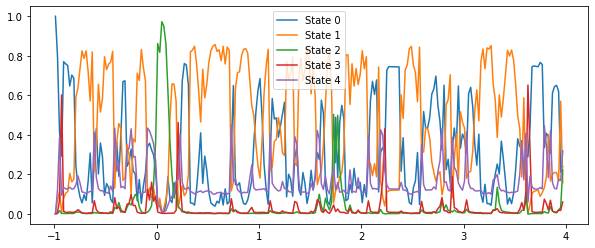

In [48]:

# get a random trial
test_trial_spikes = psth[np.random.choice(len(psth))]
posterior = hmm_.filter(test_trial_spikes)



# plot posterior of states for a single test trial
plt.figure(figsize=(10, 4))
for i in range(nstates):
    plt.plot(timebins[:-1]+binlen/1000/2,posterior[:,i], label="State %d" % i)
plt.legend()
